In [104]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import OrdinalEncoder

In [2]:
path= 'train.csv'
data= pd.read_csv(path)
df= data.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [8]:
with pd.option_context('display.max_rows', None):
    print(df.T)

                  0        1        2        3        4        5        6     \
Id                   1        2        3        4        5        6        7   
MSSubClass          60       20       60       70       60       50       20   
MSZoning            RL       RL       RL       RL       RL       RL       RL   
LotFrontage       65.0     80.0     68.0     60.0     84.0     85.0     75.0   
LotArea           8450     9600    11250     9550    14260    14115    10084   
Street            Pave     Pave     Pave     Pave     Pave     Pave     Pave   
Alley              NaN      NaN      NaN      NaN      NaN      NaN      NaN   
LotShape           Reg      Reg      IR1      IR1      IR1      IR1      Reg   
LandContour        Lvl      Lvl      Lvl      Lvl      Lvl      Lvl      Lvl   
Utilities       AllPub   AllPub   AllPub   AllPub   AllPub   AllPub   AllPub   
LotConfig       Inside      FR2   Inside   Corner      FR2   Inside   Inside   
LandSlope          Gtl      Gtl      Gtl

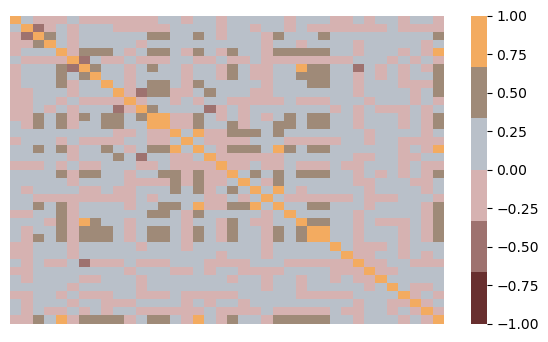

In [20]:
# We observe alot of correlation present in the numerical features.
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
plt.figure(figsize= (7, 4))
sns.heatmap(df.select_dtypes(include= 'number').corr(), cmap= cmap, vmin= -1, vmax= 1)
plt.xticks([])
plt.yticks([])
plt.show()

In [46]:
#dropping cols with nan more than 600 (half of our training examples)
mask= df.isna().sum().sort_values(ascending= False).values > 600
nan_cols= df.isna().sum().sort_values(ascending= False)[mask].index
df.drop(nan_cols, axis= 1, inplace= True)

In [53]:
#dropping nan from data
mask_nan= df.isna().sum().sort_values(ascending= False) > 0
with pd.option_context('display.max_rows', None):
    print(df.isna().sum().sort_values(ascending= False)[mask_nan])

LotFrontage     259
GarageYrBlt      81
GarageCond       81
GarageType       81
GarageFinish     81
GarageQual       81
BsmtFinType2     38
BsmtExposure     38
BsmtFinType1     37
BsmtCond         37
BsmtQual         37
MasVnrArea        8
Electrical        1
dtype: int64


In [60]:
#trying to fill the missing values in the remaining columns.
#Starting with numeric
new_nan_cols= df.isna().sum().sort_values(ascending= False)[mask_nan].index
df[new_nan_cols].select_dtypes(include= 'number')

,LotFrontage,GarageYrBlt,MasVnrArea
0,65.0,2003.0,196.0
1,80.0,1976.0,0.0
2,68.0,2001.0,162.0
3,60.0,1998.0,0.0
4,84.0,2000.0,350.0
...,...,...,...
1455,62.0,1999.0,0.0
1456,85.0,1978.0,119.0
1457,66.0,1941.0,0.0
1458,68.0,1950.0,0.0


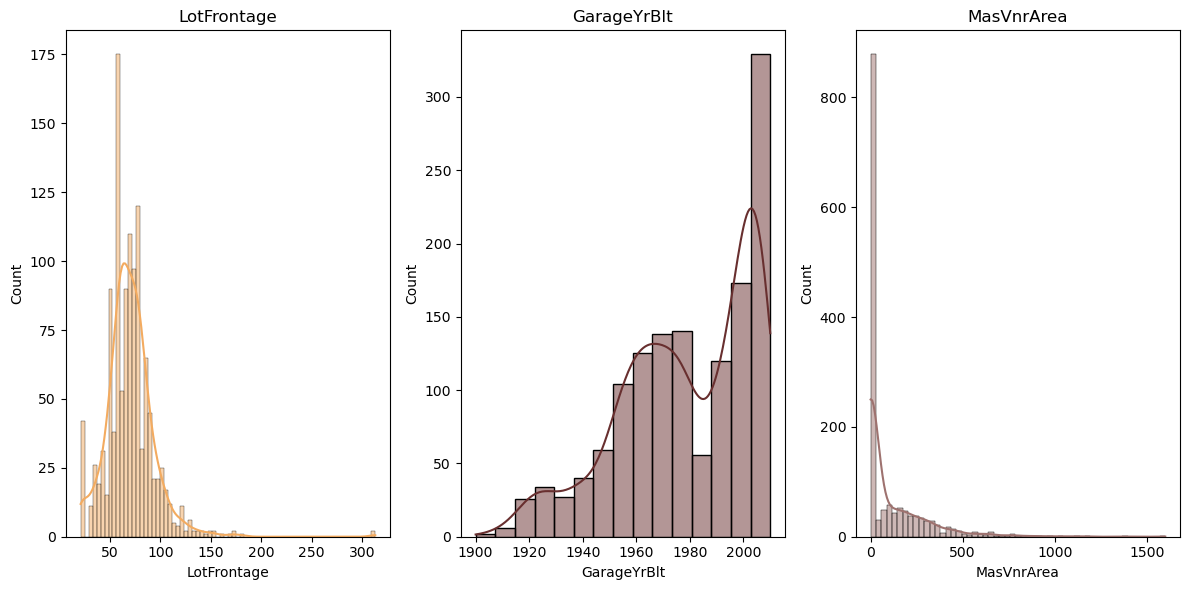

In [72]:
#they're all skewed so using the median might be a good choice
fig, ax= plt.subplots(1, 3, figsize= (12, 6))
cols = ['LotFrontage', 'GarageYrBlt', 'MasVnrArea']
colors = ['#F3AB60', '#682F2F', '#9E726F']

for i, col in enumerate(cols):
    sns.histplot(df[col].dropna(), kde=True, ax=ax[i], color=colors[i])
    ax[i].set_title(col)

plt.tight_layout()
plt.show()

In [78]:
nan_num_cols= df[new_nan_cols].select_dtypes(include= 'number').columns
nan_median= df[nan_num_cols].median()
df[nan_num_cols]= df[nan_num_cols].fillna(nan_median)

In [91]:
for i in df[new_nan_cols].select_dtypes(include= 'object').columns:
    print('N° of unique elements in', i,'is:', len(df[i].unique()))
    print('--------------------------------------------')

N° of unique elements in GarageCond is: 6
--------------------------------------------
N° of unique elements in GarageType is: 7
--------------------------------------------
N° of unique elements in GarageFinish is: 4
--------------------------------------------
N° of unique elements in GarageQual is: 6
--------------------------------------------
N° of unique elements in BsmtFinType2 is: 7
--------------------------------------------
N° of unique elements in BsmtExposure is: 5
--------------------------------------------
N° of unique elements in BsmtFinType1 is: 7
--------------------------------------------
N° of unique elements in BsmtCond is: 5
--------------------------------------------
N° of unique elements in BsmtQual is: 5
--------------------------------------------
N° of unique elements in Electrical is: 6
--------------------------------------------


In [98]:
nan_median

LotFrontage      69.0
GarageYrBlt    1980.0
MasVnrArea        0.0
dtype: float64

In [ ]:
#encoding all columns with their mode
nan_obj_cols= df[new_nan_cols].select_dtypes(include= 'object').columns
df[nan_obj_cols] = df[nan_obj_cols].apply(lambda x: x.fillna(x.mode()[0]))

,GarageCond,GarageType,GarageFinish,GarageQual,BsmtFinType2,BsmtExposure,BsmtFinType1,BsmtCond,BsmtQual,Electrical
0,TA,Attchd,Unf,TA,Unf,No,Unf,TA,TA,SBrkr


In [107]:
# fitting tree based model to determine feature importance:
inputs= df.drop('SalePrice', axis= 1)
target= df[['SalePrice']]
#encoding categories
ore= OrdinalEncoder()
inputs= ore.fit_transform(inputs)

In [109]:
#fitting xgbRegressor
xgb= XGBRegressor()
xgb.fit(inputs, target)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


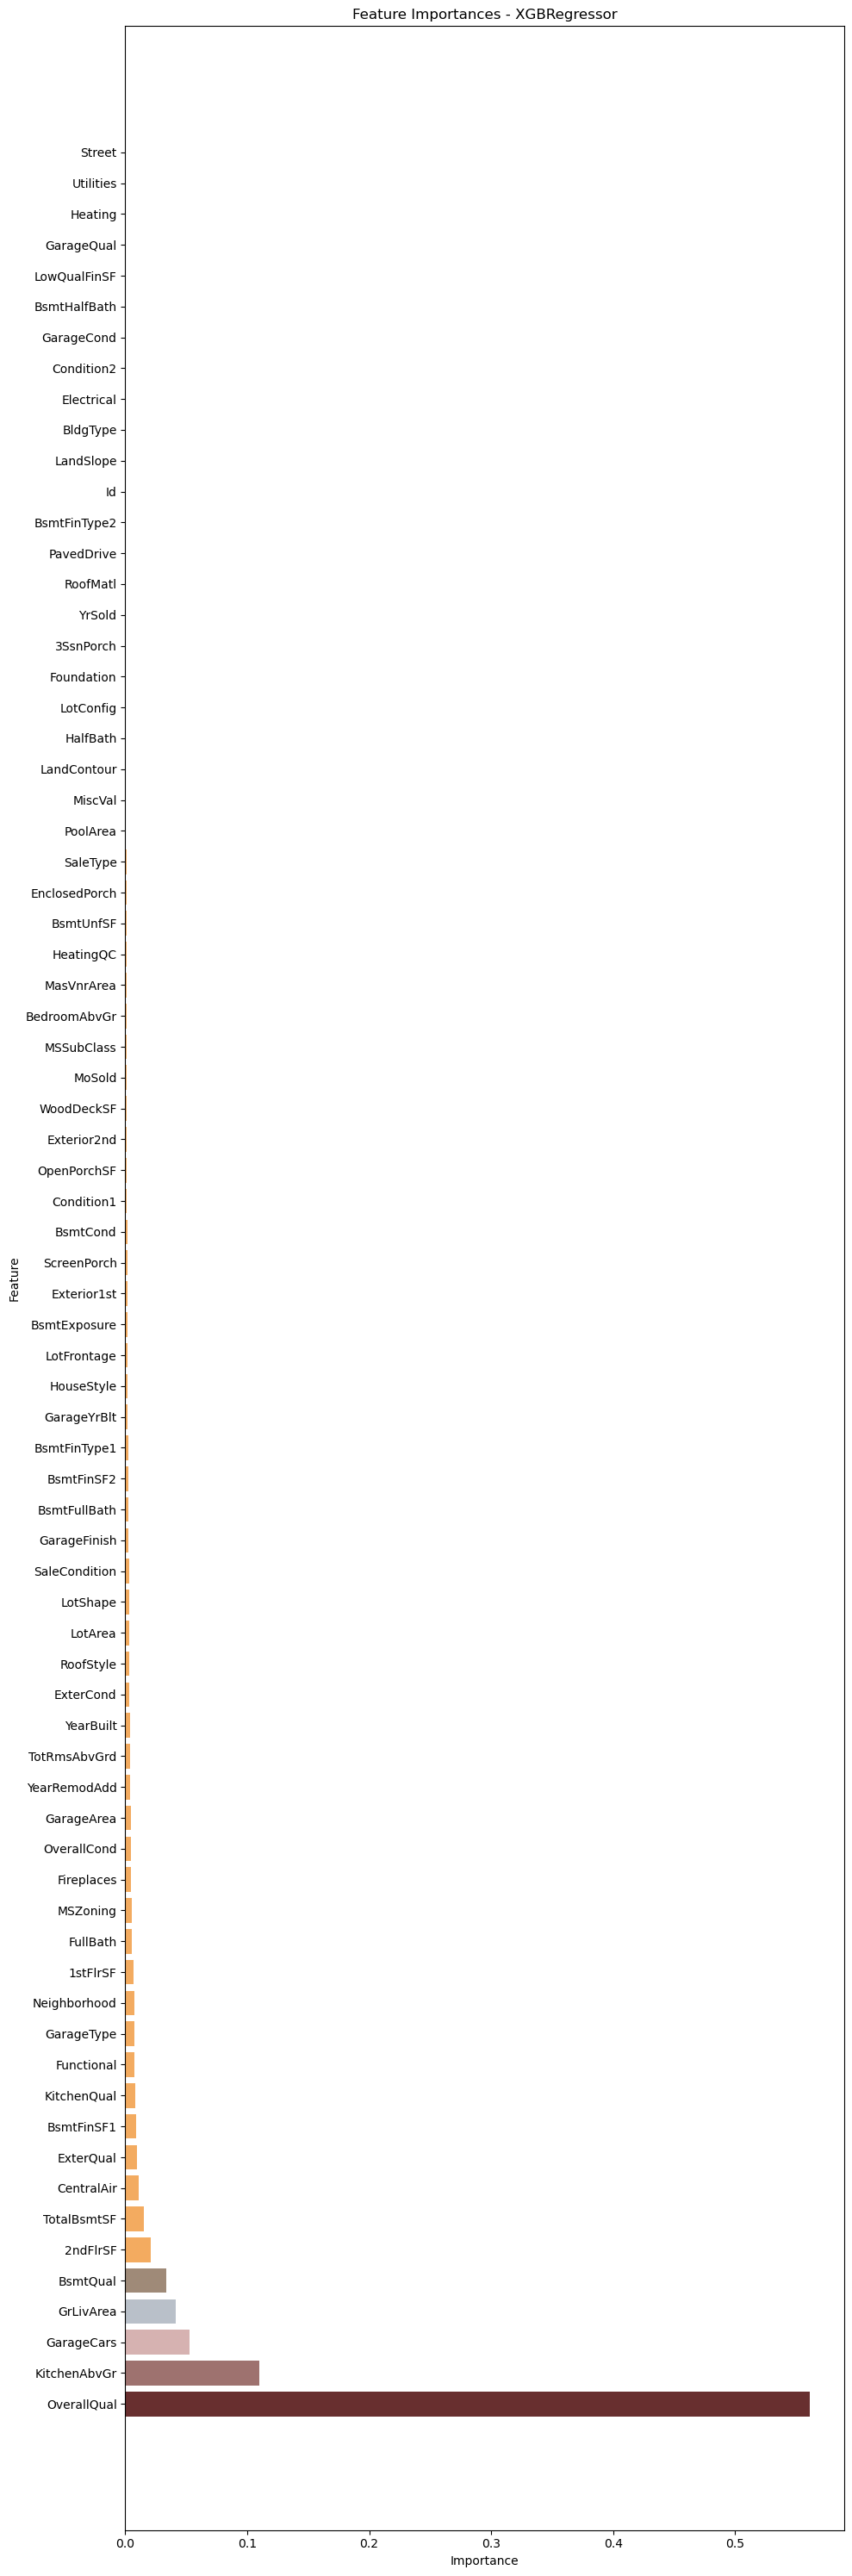

In [118]:
importances= xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'feature': df.drop('SalePrice', axis= 1).columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)

plt.figure(figsize=(10,30))
bars = plt.barh(
    feature_importance_df['feature'],
    feature_importance_df['importance'],
    color=cmap(range(len(feature_importance_df)))
)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importances - XGBRegressor")
plt.tight_layout()
plt.show()

In [ ]:
threshold = 0.01  # e.g., 1% of max importance
selected_features = feature_importance_df[
    feature_importance_df['importance'] > threshold * feature_importance_df['importance'].max()
]['feature'].tolist()

In [131]:
mask_fi= feature_importance_df['importance'] >= 0.009
final_features= list(feature_importance_df[mask_fi]['feature'].values)
final_features

['OverallQual',
 'KitchenAbvGr',
 'GarageCars',
 'GrLivArea',
 'BsmtQual',
 '2ndFlrSF',
 'TotalBsmtSF',
 'CentralAir',
 'ExterQual',
 'BsmtFinSF1']

### Model Selection

In [148]:
#splitting
inputs= df[final_features]
target= df[['SalePrice']]
x_train, x_test, y_train, y_test= tts(inputs, target, test_size= .2, random_state= 22)

In [152]:
category_cols= inputs.select_dtypes(include= 'object').columns
ore= OrdinalEncoder()
x_train[category_cols]= ore.fit_transform(x_train[category_cols])
x_test[category_cols]= ore.transform(x_test[category_cols])

In [ ]:
xgbr= XGBRegressor()
xgbr.fit(x_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [156]:
y_pred= xgbr.predict(x_test)

In [159]:
from sklearn.metrics import r2_score, root_mean_squared_error as rmse

In [157]:
r2_score(y_test,y_pred)

0.8280641436576843

In [161]:
rmse(y_test, y_pred)

32469.6796875